In [1]:
# standard imports
import numpy as np
from tqdm import tqdm
import meshio
import matplotlib.pyplot as plt

In [2]:
# import geometry classes
from geometry.node import node
from geometry.cell import cell
from geometry.mesh import rot_sym_mesh
from problem.isentropic_navier_stokes import convection, diffusion, skalar_product,curl

# utility functions
from utilities.utilities import *
from utilities.pod_2 import get_POD, get_activations

# Setting Custom Problem

In [3]:
# read su2 mesh file
meshio_mesh = meshio.read("./mesh_files/mesh_cylinder_quad.su2",file_format="su2")
# convert mesh into custom class exp_mesh
mesh = rot_sym_mesh(meshio_mesh)

    Surface tag  cylinder will be replaced by 1
    Surface tag  farfield will be replaced by 2
Initializing Mesh---------------------------------------------------------------
Mesh Initialization Successful!-------------------------------------------------


# Geometric Constants

In [4]:
# DEFINING CONSTANTS
n = mesh.n          # number of nodes
N = mesh.N          # number of cells
T = 180             # number of snapshots
alpha = 1           # inner product coefficient  # method for derivative computation
gamma = 1.4         # isentropic coefficient -> material property
max_POD = 40        # maximum number of POD modes
mach = 0.6          # mach number
sos = 340.29        # isentropic speed of sound
u_free = mach * sos # freestream velocity
Re = 100            # Reynolds number of freeflow
include_avg = False # include average flow in POD computation
nondim = True       # apply nondimensionalization to data

# Data Preparation

In [5]:
# reading file data
data_dir  = "./flow_data./lam_cyl_comp_air/mach 0.6 chirp/"
data_dict = read_csv_data(data_dir,delay=0,subsampling=6,max_size=T)

# geometric information
x = data_dict["x"][:,0] - 0.5
y = data_dict["y"][:,0]

# fluid velocity and mach number
u = np.divide(data_dict['Momentum_x'], data_dict['Density'])
v = np.divide(data_dict['Momentum_y'], data_dict['Density'])
if nondim:
    u = u / (mach * sos)
    v = v / (mach * sos)
    u_free = 1
a = data_dict['Mach']

# construct state based data
q = np.vstack([u,v,a])
T = q.shape[1]
q_avg = np.mean(q,1)
q_fluc = q - np.repeat(np.expand_dims(q_avg,1),T,axis=1)

# data for pod decomposition
if include_avg:
    pod_data = q
else:
    pod_data = q_fluc

### set scalar weights for multiplicative computation
# volume participations
volume_weight = mesh.volume_weights
# additional weight for speed of sound
mach_weight = (2 * alpha / (gamma - 1))
# construction of weights
inner_weight = np.concatenate([np.ones(n),np.ones(n),mach_weight*np.ones(n)]) * volume_weight

100%|██████████| 166/166 [00:55<00:00,  2.97it/s]


# POD Decomposition

In [17]:
[pod_modes, S] = get_POD(pod_data,inner_weight,20)
coeffs = get_activations(pod_data,pod_modes,inner_weight,20)

In [31]:
sum = 0
for i in range(T):
    rec = np.zeros((3*n))
    for j in range(20):
        rec += pod_modes[:,j] * q_fluc[:,i]  * pod_modes[:,j]
    sum += np.sum(q_fluc[:,i] - rec)**2

In [29]:
sum

41816678.5230863

In [7]:
# energy reconstruction threshold
epsilon = 0.99
acc = 0
num = 0
while acc < epsilon:
    num+=1
    acc = sum(S[:num])/sum(S)    
print("Number of eigenvectors necessary for thresholded reconstruction: \t" + str(num))
if num % 2 == 1:
    num+=1

# manual value
num = 4

Number of eigenvectors necessary for thresholded reconstruction: 	5


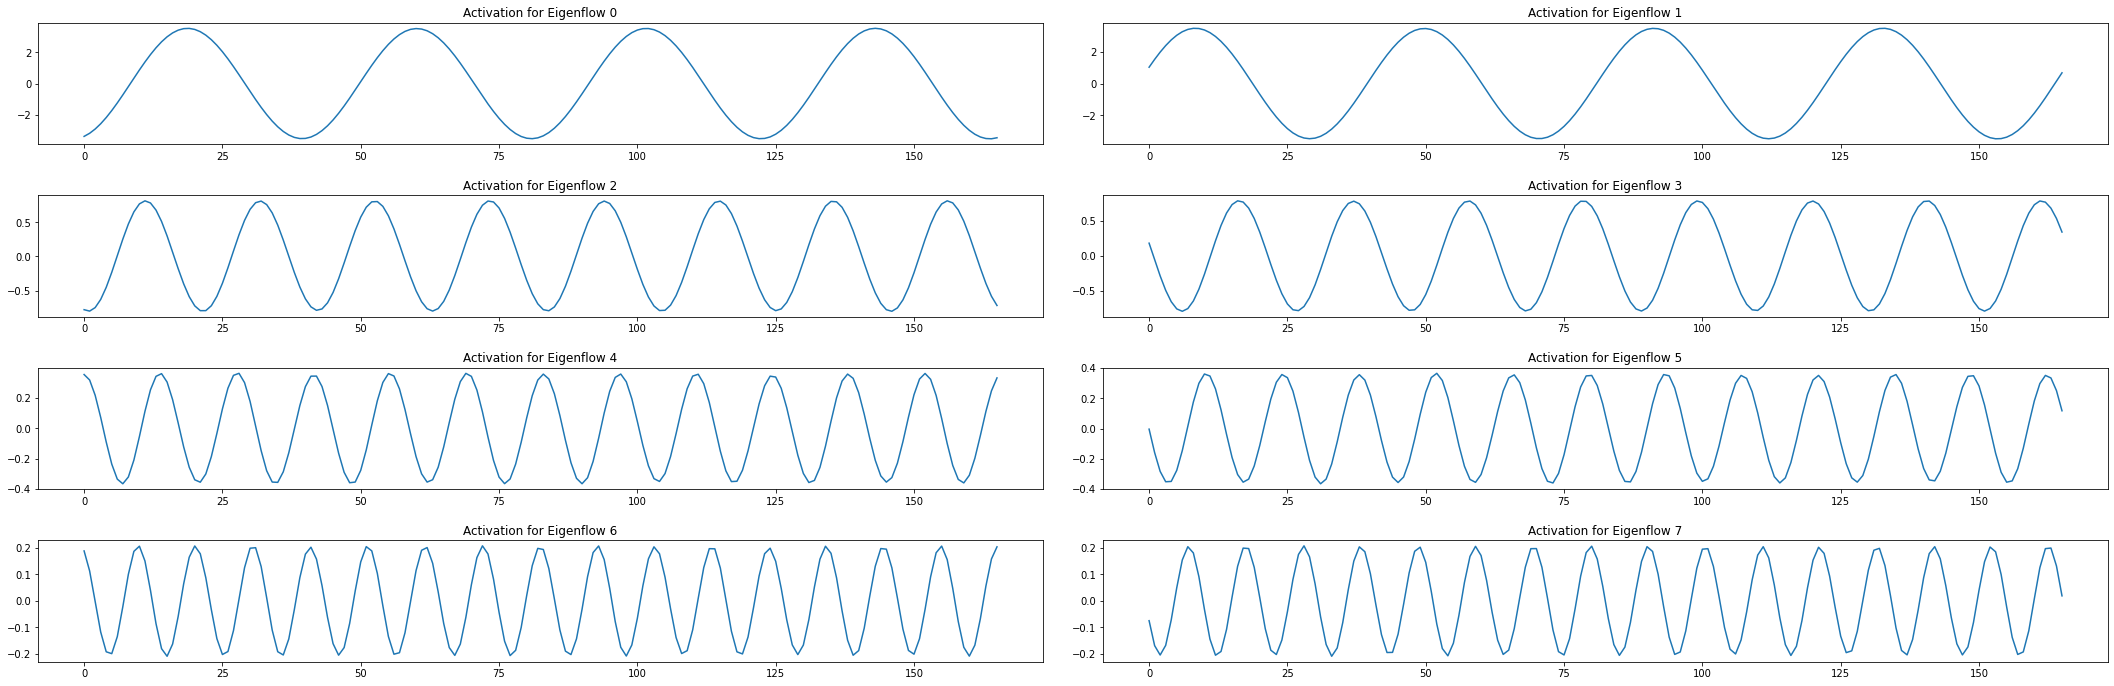

In [8]:
plot_activations(coeffs,8)

# Galerkin system

In [9]:
# Galerkin system coefficients
# Computation of Galerkin system parameters
Qavg = convection(mesh,q_avg,q_avg)
Lavg = diffusion(mesh,q_avg)

# initialie arrays for parameters
b1 = np.empty(num)
b2 = np.empty(num)
L1 = np.empty((num,num))
L2 = np.empty((num,num))
Q_ = [np.empty((num,num,)) for x in range(num)]

# compute L and Q operators for projection
Q_tmp1 = np.empty((num,3*n))
Q_tmp2 = np.empty((num,3*n))
Q_tmp3 = np.empty((num,num,3*n))
L_tmp = np.empty((num,3*n))

for i in tqdm(range(num)):
    Q_tmp1[i] = convection(mesh,q_avg,pod_modes[:,i])
    Q_tmp2[i] = convection(mesh,pod_modes[:,i],q_avg)
    L_tmp[i] = diffusion(mesh,pod_modes[:,i])
    for j in range(num):
        Q_tmp3[i,j] = convection(mesh,pod_modes[:,i],pod_modes[:,j])

# compute ODE coefficients
for k in tqdm(range(num)):
    b1[k] = skalar_product(Lavg,pod_modes[:,k],inner_weight)
    b2[k] = skalar_product(Qavg,pod_modes[:,k],inner_weight)
    for i in range(num):
        L1[k,i] = skalar_product(L_tmp[i],pod_modes[:,k],inner_weight)
        L2[k,i] = skalar_product(np.add(Q_tmp1[i],Q_tmp2[i]),pod_modes[:,k],inner_weight)
        for j in range(num):
            Q_[k][i,j] = skalar_product(Q_tmp3[i,j],pod_modes[:,k],inner_weight)

100%|██████████| 4/4 [00:00<00:00, 235.20it/s]


In [10]:
### bc penalty term
# velocity on boundary 
boundary_weight = np.zeros(3*n)

# compute ds
rad = mesh.points_pol[-200,0]
ds = 2 * np.pi * rad / 200

# set boundary weights for skalar product
boundary_weight[n-200:n] = ds
boundary_weight[2*n-200:2*n] = ds
boundary_weight[3*n-200:3*n] = ds * mach_weight

# state based freestream condition
q_inf = np.concatenate([np.repeat(u_free,n),np.zeros(n),np.repeat(0.6,n)])

# bc
G1 = np.empty((num,num))
G2 = np.empty(num)
for i in range(num):
    for j in range(i,num):
        G1[i,j] = skalar_product(pod_modes[:,i],pod_modes[:,j],boundary_weight)
        G1[j,i] = G1[i,j]
    G2[i] = skalar_product(pod_modes[:,i],q_inf,boundary_weight)

In [11]:
# initial conditions
a0 = coeffs[:num,20]

# sampling span for solver
t0 = 0
dt = 0.01
tmax = 60
sampling_span = np.linspace(t0,tmax-dt,num=int(tmax/dt))
tau = 5
# static viscosity
nu = 4.45/100

# defining ode function for node based coefficients
def galerkin_system(t,a):
    # set global variables references
    global Q_, L1, L2, b1, b2, nu
    
    a_dot = np.empty_like(a)
    
    for k in range(a_dot.shape[0]):
        a_dot[k] = (nu * b1[k] + b2[k] + np.inner((nu*L1[k,:]+L2[k,:]),a) + np.matmul(np.matmul(np.expand_dims(a,1).T,Q_[k]),np.expand_dims(a,1))) # - (tau * (np.inner(G1[k,:],a) - G2[k]))
    return a_dot

In [12]:
from scipy.integrate import solve_ivp
sol = solve_ivp(galerkin_system,(t0,tmax),a0,method='LSODA',t_eval=sampling_span)
sol.message

'The solver successfully reached the end of the integration interval.'

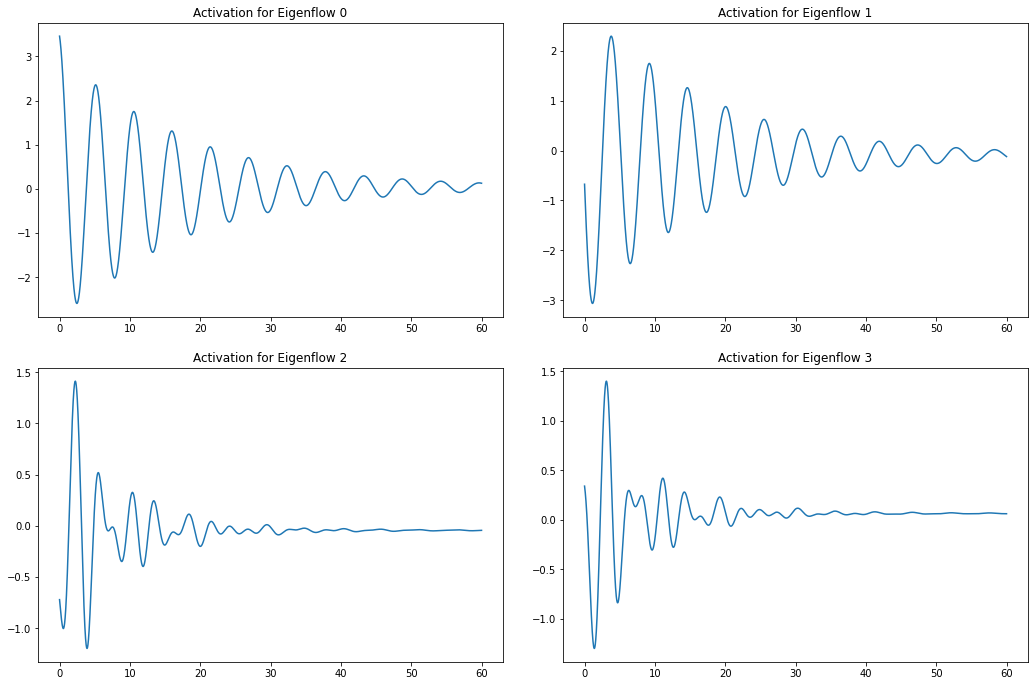

In [13]:
# Galerkin model based on discrete reconstruction as q = \bar{q}+\sum_i^n a_i(t)*\phi_i(x)
d = int(num/2)
fig,ax = plt.subplots(d,2,figsize=(15,10))
fig.tight_layout(pad=3.0)

t = sampling_span

# add plots over full time domain
for i in range(num):
    if num <= 2:
        ax[int(i%2)].plot(t,sol.y[i,:len(t)])
        ax[int(i%2)].title.set_text("Activation for Eigenflow " + str(i))
    else:
        ax[int(i/2)][int(i%2)].plot(t,sol.y[i,:len(t)])
        ax[int(i/2)][int(i%2)].title.set_text("Activation for Eigenflow " + str(i))